In [85]:
%matplotlib inline

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from celeriteflow import ops

In [126]:
session = tf.Session()

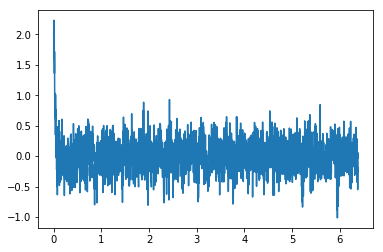

In [127]:
data = np.loadtxt('211351816.dat.ts')

T = tf.float64

t = tf.constant(data[:, 0]*0.0864, dtype=T)
y = tf.constant(data[:, 1:2]*1e3, dtype=T)

log_var = np.log(np.var(data[:,1]*1e3))

plt.plot(*(session.run([t, y])))

In [148]:
log_jitter = tf.Variable(log_var, dtype=T)
log_numax = tf.Variable(np.log(220.0), dtype=T)
log_dnu = tf.Variable(np.log(17.0), dtype=T)
gamma = tf.Variable([0.0, 0.0], dtype=T)
log_H = tf.Variable([log_var, log_var], dtype=T)
log_sigma = tf.Variable(np.log(10.0), dtype=T)
log_Q = tf.Variable(10., dtype=T)

numax = tf.exp(log_numax)
nprime = tf.range(-2.0, 3.0, dtype=T)
ell = tf.range(2, dtype=T)
nu = numax + gamma[None, :] + (tf.exp(log_dnu) * (nprime[:, None] + 0.5*ell[None, :]))
log_amp = log_H[None, :] - 0.5*tf.square(nu - numax)*tf.exp(-2*log_sigma)

w0 = 2*np.pi*nu
Q = 1.0 + tf.exp(log_Q)  # Make sure that Q is always greater than 1
Q2 = tf.square(Q)
S0 = tf.exp(log_amp) / Q2

f = tf.sqrt(4.0 * Q2 - 1.0)
nada = tf.constant([], dtype=T)
a = tf.reshape(S0 * w0 * Q, [-1])
b = tf.reshape(S0 * w0 * Q / f, [-1])
c = tf.reshape(0.5 * w0 / Q, [-1])
d = tf.reshape(0.5 * w0 / Q * f, [-1])

# Granulation terms
log_S0_gran = tf.Variable([log_var - 10.0, log_var - 10.0], dtype=T)
log_w0_gran = tf.Variable(np.log([2*np.pi*100.0, 2*np.pi*150.0]), dtype=T)

arg1 = tf.exp(log_S0_gran + log_w0_gran)
arg2 = 0.5 * tf.exp(log_w0_gran)
a = tf.concat([a, arg1], 0)
b = tf.concat([b, arg1], 0)
c = tf.concat([c, arg2], 0)
d = tf.concat([d, arg2], 0)

# Power spectrum
freq = tf.placeholder_with_default(
    np.linspace(10, 280, 10000),
    (10000, )
)
omega = 2 * np.pi * freq
num = (a * c + b * d) * (tf.square(c) + tf.square(d)) + (a * c - b * d) * tf.square(omega)[:, None]
denom = (omega**4)[:, None] + 2*(tf.square(c) - tf.square(d)) * tf.square(omega)[:, None] + tf.square(tf.square(c) + tf.square(d)) 
psd = np.sqrt(2.0 / np.pi) * tf.reduce_sum(num / denom, 1)

# GP model
A, U, V, P = ops.get_celerite_matrices(nada, nada, a, b, c, d, t, tf.exp(log_jitter) + tf.zeros_like(t))
D, W = ops.celerite_factor(A, U, V, P)
z = ops.celerite_solve(U, P, D, W, y)

chi2 = tf.squeeze(tf.matmul(y, z, transpose_a=True)) + tf.reduce_sum(tf.log(D))

session.run(tf.global_variables_initializer())
print(session.run(chi2))
session.run(tf.gradients(chi2, [log_S0_gran, log_w0_gran]))

-5558.388502137681


[array([-64.1706706 , -47.28500978]), array([ 0.98242426, 27.09230808])]

In [149]:
# # Hacks to test gradients
# eps = 1e-5
# var = y
# targ = tf.reduce_sum(z)
# v = session.run(var)
# g0 = session.run(tf.gradients(targ, var))[0].flatten()

# s = v.shape
# v = v.flatten()
# g = np.empty_like(v)
# for i in range(len(v)):
#     eye = np.zeros_like(v)
#     eye[i] = eps
#     p = session.run(targ, feed_dict={var: (v+eye).reshape(s)})
#     m = session.run(targ, feed_dict={var: (v-eye).reshape(s)})
#     g[i] = 0.5 * (p - m) / eps
    
# inds = [0, 1, 2, 3, -4, -3, -2, -1]
# g[inds], g0[inds], np.max(np.abs(g - g0))

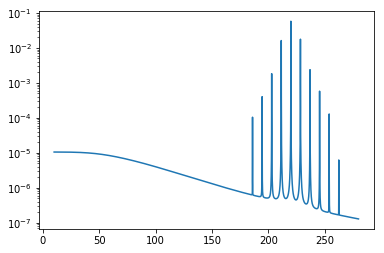

In [91]:
plt.semilogy(*session.run([freq, psd]))

In [92]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=[log_S0_gran, log_w0_gran])

print(session.run([log_S0_gran, log_w0_gran]))
opt.minimize(session)
print(session.run([log_S0_gran, log_w0_gran]))

[array([-12.62076403, -12.62076403]), array([6.44304725, 6.84851236])]
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -6071.863484
  Number of iterations: 16
  Number of functions evaluations: 61
[array([-10.13292961,  -7.9757009 ]), array([5.59131348, 4.0406287 ])]


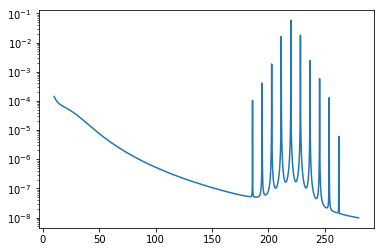

In [93]:
plt.semilogy(*session.run([freq, psd]))

In [150]:
def gridsearch(session,target,var,grid,index=0):
    target_grid = np.empty_like(grid)
    var_init = session.run(var)
    shape = np.shape(var_init)
    var_init = np.atleast_1d(var_init)
    for i, value in enumerate(grid):
        var_init[index] = value
        target_grid[i] = session.run(target, feed_dict={var: np.reshape(var_init, shape)})
    var_init[index] = grid[np.argmin(target_grid)]
    session.run(tf.assign(var, np.reshape(var_init, shape)))
    return target_grid

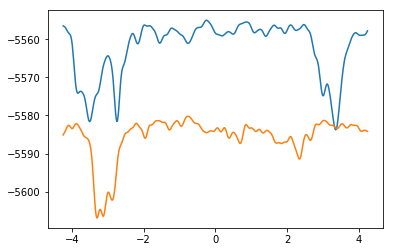

In [151]:
dn = session.run(log_dnu)
grid = np.linspace(-0.25*np.exp(dn),0.25*np.exp(dn), 500)

chi2_grid = gridsearch(session,chi2,gamma,grid,0)
plt.plot(grid, chi2_grid)

chi2_grid = gridsearch(session,chi2,gamma,grid,1)
plt.plot(grid, chi2_grid)


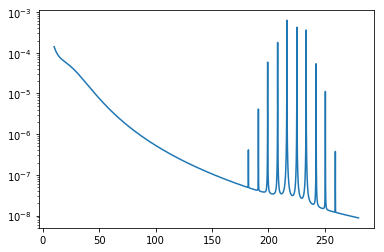

In [109]:
plt.semilogy(*session.run([freq, psd]))

In [110]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=[gamma])

print(session.run([gamma]))
opt.minimize(session)
print(session.run([gamma]))

[array([-3.61686278, -3.29194367])]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6152.592113
  Number of iterations: 3
  Number of functions evaluations: 6
[array([-3.61238337, -3.28989623])]


In [111]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=[log_H])

print(session.run([log_H]))
opt.minimize(session)
print(session.run([log_H]))

[array([-5.12791615, -5.73277798])]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -6153.050756
  Number of iterations: 3
  Number of functions evaluations: 5
[array([-5.64443667, -5.75022687])]


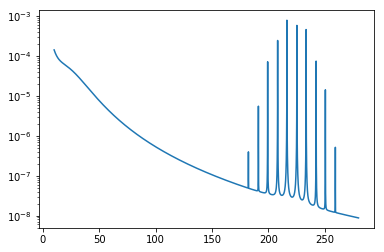

In [112]:
plt.semilogy(*session.run([freq, psd]))

In [113]:
var_list = [log_Q, log_H, gamma, log_S0_gran, log_w0_gran]
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=var_list)

print(session.run(var_list))
opt.minimize(session)
print(session.run(var_list))

[10.0, array([-5.64443667, -5.75022687]), array([-3.61238337, -3.28989623]), array([-10.13292956,  -7.97570013]), array([5.59131653, 4.04063132])]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6153.051396
  Number of iterations: 2
  Number of functions evaluations: 42
[10.000113929356802, array([-5.64443667, -5.75022687]), array([-3.6116294 , -3.28982581]), array([-10.13298291,  -7.97556033]), array([5.5915864 , 4.04099295])]


In [152]:
#proposed schedule: 0. inititialize vars, 1.optimize gran params, 2.gridsearch gamma, 3. opt all but numax/dnu, 4. grid numax/dnu, 5. optimize all params, 6. return to 2

def optimize(variables):
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, var_list=variables)
    opt.minimize(session)

variables = [gamma, log_numax, log_dnu]#, log_sigma, log_H, log_jitter, log_S0_gran, log_w0_gran]#, log_numax, log_sigma, log_Q, log_H, log_jitter] 

optimize(variables)

dn = session.run(log_dnu)
grid = np.linspace(-0.25*np.exp(dn),0.25*np.exp(dn), 500)

chi2_grid = gridsearch(session,chi2,gamma,grid,0)
plt.plot(grid, chi2_grid)

chi2_grid = gridsearch(session,chi2,gamma,grid,1)
plt.plot(grid, chi2_grid)





INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -5634.939277
  Number of iterations: 26
  Number of functions evaluations: 41


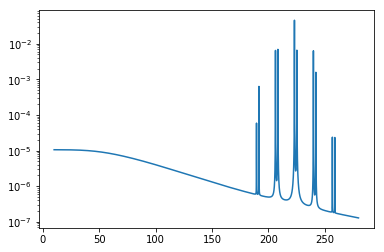

In [153]:
plt.semilogy(*session.run([freq, psd]))

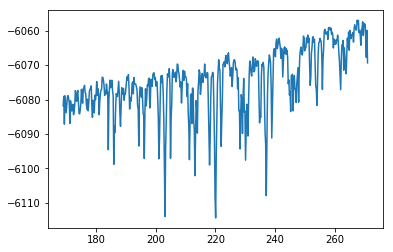

In [98]:
val0, dn = session.run([log_numax, log_dnu])
grid = np.log(np.exp(val0) + np.linspace(-3*np.exp(dn),3*np.exp(dn), 500))
chi2_grid = gridsearch(session,chi2,log_numax,grid)
plt.plot(np.exp(grid), chi2_grid)

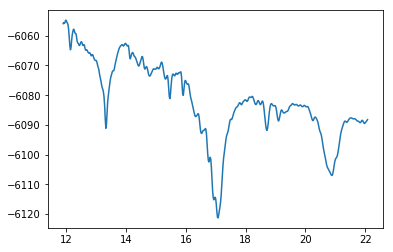

In [99]:
dn = session.run(log_dnu)
grid = np.log(np.linspace(-0.3*np.exp(dn),0.3*np.exp(dn), 500)+np.exp(dn))
chi2_grid = gridsearch(session,chi2,log_dnu,grid)
plt.plot(np.exp(grid), chi2_grid)